# Capstone: Semi-Supervised Approach for Food Consumption Inference using Non-Intrusive Bio-Signals
###  Allen Nikka (405027870) 
Link to paper [here](https://docs.google.com/document/d/1LhGf0zWXSXxt7arJvlnYhvE4nthrO3RsW4lbYn3ZBbU/edit?usp=sharing)

## Load Requisite Libraries

In [1]:
# Utilities
from tqdm import tqdm_notebook as tqdm
import os
import pdb
import glob

# Numerical
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Preprocessing / Filtering
from scipy.ndimage import gaussian_filter1d

# Unsupervised learning: https://scikit-learn.org/stable/unsupervised_learning.html
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.mixture import GaussianMixture

# My Utilities
import pulseoxLoader as loader

# Plots
%matplotlib notebook

## Fetch all data files

In [2]:
data_path = "C:/Users/allen/Documents/OSCAR_Data-pulseox-data"
label_path = os.path.join(data_path, "data_labels.csv")
# print(os.listdir(data_path))
csv_path = os.path.join(data_path, '*.csv')
oxdata = loader.OxData(csv_path, label_path)
data_file_names = oxdata.data_file_list()
print(data_file_names)
example = os.path.join(data_path, 'OSCAR_allen_Details_2019-10-24.csv')

['OSCAR_allen_Details_2019-10-08.3.csv', 'OSCAR_allen_Details_2019-10-24.csv', 'OSCAR_allen_Details_2019-10-26.csv', 'OSCAR_allen_Details_2019-11-14.csv', 'OSCAR_allen_Details_2019-11-14_11-15_2_sessions.csv', 'OSCAR_allen_Details_2019-11-19.csv']


## Pre-Processing
### Experimenting with different parameters and accompanying visualizations

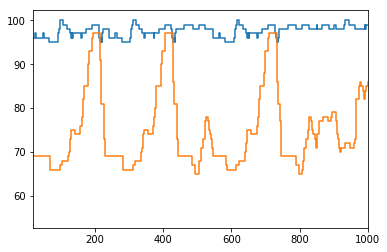

In [3]:
sp02, pulse, start_time = oxdata.day_to_df(example)
# print(sp02.head(2))
# print(pulse.head(2))
# print(start_time)
plt.clf()
plt.plot(sp02['DateTime'].values, sp02['Data/Duration'].values)
plt.plot(pulse['DateTime'].values, pulse['Data/Duration'].values)
plt.xlim(20, 1000)
plt.savefig(os.path.split(example)[-1] + '.png')
# 74720 time units for 32 minutes


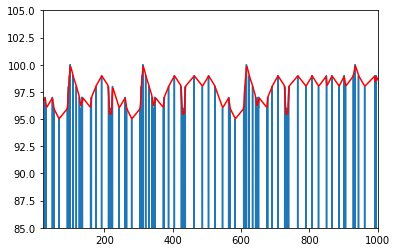

In [4]:
# Pre Processing for the FFT
wave = oxdata.preproc_df_fft(sp02, smoothing='gaussian', sigma=1, plot=True)


In [5]:
result = oxdata.gen_fft(wave, 1024)
print(result.shape)
magnitudes, angles = result[:,:result.shape[1]//2], result[:,result.shape[1]//2:]
idx = 70
# smoothing = 3
# moving_avg(magnitudes[idx], smoothing)
# moving_avg(angles[idx], smoothing)

(72, 1024)


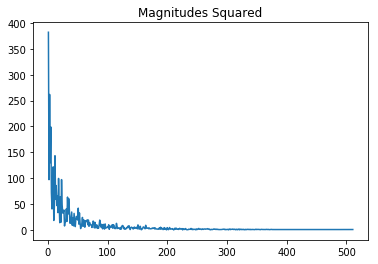

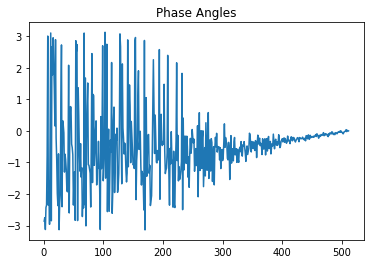

<Figure size 432x288 with 0 Axes>

In [6]:
oxdata.plot_fft(magnitudes[idx], angles[idx], offset=1)

In [7]:
# Normalize the data for each feature
X = normalize(result)

kmeans = KMeans(n_clusters=3) # TODO: Plot inertia vs number of clusters, and find 'elbow'
kmeans_pred = kmeans.fit_predict(X)
print("Inertia: {}".format(kmeans.inertia_))
# print("Cluster Centers: {}".format(kmeans.cluster_centers_))
print(kmeans.labels_)
print(kmeans_pred)
# mixture = GaussianMixture(n_components=3) #Output of GMM looks worse than kmeans for our application
# labels = mixture.fit_predict(X)
# # print(dir(mixture))


Inertia: 0.00037730088213270587
[2 2 2 2 2 2 2 1 1 1 1 2 1 2 1 1 0 1 1 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[2 2 2 2 2 2 2 1 1 1 1 2 1 2 1 1 0 1 1 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


## Perform Analysis
### Hold out some data for testing, plot results

In [8]:
hold_out_data = ['OSCAR_allen_Details_2019-11-19.csv']
sigma_val = 1
fft_size_val = 64
X = oxdata.get_data_matrix(sigma=sigma_val, hold_out=hold_out_data, reparse=True, fft_size=fft_size_val)
# Use PCA to reduce dimensionality of data. TODO: Investigate why samples were being dropped
# reduce to number of samples, inc number of samples by shrinking windows
pca = PCA(n_components=0.999) #, svd_solver='full') 
Xp = pca.fit_transform(X)
component_num = Xp.shape[1]
print(Xp.shape)
print(X.shape)

(3868, 14)
(3868, 128)


In [9]:
Ks = [i+1 for i in range(10)]
inertias = []
for k in tqdm(Ks):
    kmeans = KMeans(n_clusters=k, n_jobs=-1)
    kmeans_pred = kmeans.fit_predict(X)
#     kmeans_pred = kmeans.fit_predict(Xp)
    inertias.append(kmeans.inertia_)

### Determine appropriate value of K using elbow-method

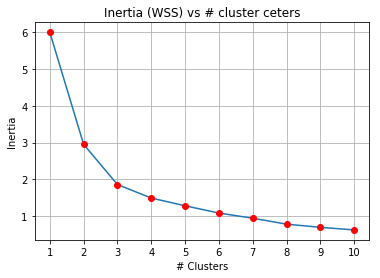

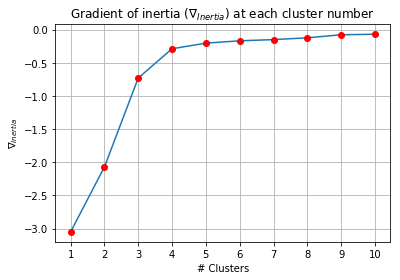

In [10]:
# deltas = [inertias[i] - inertias[i-1] for i in range(1, len(inertias))]
deltas = np.gradient(inertias)
plt.clf()
plt.title("Inertia (WSS) vs # cluster ceters")
plt.xlabel("# Clusters")
plt.ylabel("Inertia")
plt.xticks(Ks)
plt.plot(Ks, inertias)
plt.plot(Ks, inertias, 'ro')
plt.grid()
plt.show()

plt.clf()

plt.title(r"Gradient of inertia ($\nabla_{Inertia}$) at each cluster number")
plt.xlabel("# Clusters")
plt.ylabel(r"$\nabla_{Inertia}$")
plt.xticks(Ks)
plt.plot(Ks, deltas)
plt.plot(Ks, deltas, 'ro')
plt.grid()
plt.show()
# print(deltas)

### Use computed value of K to compute cluster centers 

In [11]:
hold_out_paths = []
for fname in hold_out_data:
    hold_out_paths.append(os.path.join(data_path, fname))
kmeans_optimized = KMeans(n_clusters=3, n_jobs=-1)
kmeans_optimized.fit(X)
# kmeans_optimized.fit(Xp)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [14]:
df = oxdata.labels_to_df(label_path, '11/19/2019')
labels = oxdata.gen_ground_truth(df, 0, 2, 1)
print(labels)

[0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1
 1 1 1 1 1 1 1 1 1 1]


<Figure size 432x288 with 0 Axes>

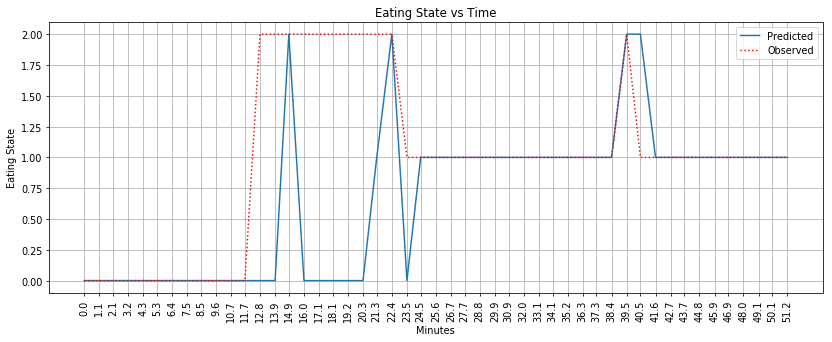

In [15]:
for p in hold_out_paths:
    Xn = oxdata.csv_to_data(p, normalize=True, fft_size=fft_size_val, sigma=sigma_val)
#     pca = PCA(n_components=component_num, svd_solver='full') 
#     Xn = pca.fit_transform(Xn)
    res = kmeans_optimized.predict(Xn)
    plt.clf()
    plt.figure(figsize=(12,5),dpi=70)
    t = np.round((fft_size_val/60)*np.arange(len(res)), 1)
    plt.xticks(t)
    plt.xticks(rotation=90)
    plt.xlabel("Minutes")
    plt.ylabel("Eating State")
    plt.title("Eating State vs Time")
    plt.plot(t, res)
    l2 = np.zeros(res.shape) + labels[0]
    delta = np.round(np.abs(l2.shape[0] - len(labels)))
    l2[delta:delta+len(labels)] = labels

    plt.plot(t, l2, 'r:')
    plt.legend(["Predicted", "Observed"])
    plt.grid()
    plt.tight_layout()
    plt.show()

### Results
* Seems that Pre-Eating, Post-Eating, and Just-Ate states are clearly seperated based on WSS curves and time plot
* Consistently see eating behavior push my biosignals to post-eating state 2-4 minutes after eating
* Signal falls off very quickly after that